---
# How do dataset sizes and noise levels affect polynomial fits?
---

In this example, we generate videos that show that 
1. Increasings the noise level in data <b>reduces</b> the regression performances.
2. Increasing the size of datasets <b>increases</b> the regression performances.

The script considers 1-D fits only. The conclusions we draw from this exercise can be applied to higher-dimension datasets. 


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
sns.set(color_codes=True)

import cv2
import os

# Used for reproductibility of the results
np.random.seed(43)

Automatically created module for IPython interactive environment


## Function for dataset generation


In [2]:
# Our baseline model is a quadratic polynomial with the following parameters:
coeffs = [0.03, 0.2, -2]

x_min = -2.5
x_max = 10.
xx = np.linspace(x_min,x_max,100)[:,np.newaxis]

# Function that generates a random (x,y) dataset with the y data corrupted with some gaussian noise.
def generate_data(N, sigma):
    x = np.random.uniform(x_min,x_max,N)
    y = np.polyval(coeffs,x) + np.random.normal(0.0, sigma, N)

    return x, y


In [3]:
## Displaying functions

In [4]:
# Function that fits the (x,y) dataset with polynomials of orders = 1, 2 and 9. The displayed results 
# are saved in a temporary directory before being converted into a video.

def generate_fits(i, title, image_folder='./Temporary'):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(12,10))
    plt.suptitle(title)
    
    # Original data
    yy0 = np.polyval(coeffs,xx)
    ax1.plot(xx, yy0, color='black', linewidth=1)
    ax1.plot(x, y, 'o', color='black', markersize=1)
    ax1.set_ylabel('y',rotation=0,fontsize=18)
    ax1.set_xlabel('x',fontsize=18)
    ax1.yaxis.set_label_coords(-0.1,0.5)
    ax1.xaxis.set_label_coords(0.5, -0.05)
    ax1.set_xlim(-3., 10.)
    ax1.set_ylim(-3., 3.)
    str = 'Original Data (N = %d)' % (N)
    ax1.legend(['Quadratic Model', str], loc='upper left')
    ax1.set_facecolor('#BBBBFF')

    # Linear fit
    c = np.polyfit(x, y, 1)
    yy = np.polyval(c,xx)
    ax2.plot(xx, yy, linestyle='--', color='red', linewidth=4)
    ax2.plot(xx, yy0, color='black', linewidth=1)
    ax2.plot(x, y, 'o', color='black', markersize=1)
    ax2.set_ylabel('y',rotation=0,fontsize=18)
    ax2.set_xlabel('x',fontsize=18)
    ax2.yaxis.set_label_coords(-0.1,0.5)
    ax2.xaxis.set_label_coords(0.5, -0.05)
    ax2.legend([r"$1^{st}$ order Polynomial"], loc='upper left')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
    ax2.set_facecolor('#BBBBFF')

    # Quadratic fit
    c = np.polyfit(x, y, 2)
    yy = np.polyval(c,xx)
    ax3.plot(xx, yy, linestyle='--', color='red', linewidth=4)
    ax3.plot(xx, yy0, color='black', linewidth=1)
    ax3.plot(x, y, 'o', color='black', markersize=1)
    ax3.set_ylabel('y',rotation=0,fontsize=18)
    ax3.set_xlabel('x',fontsize=18)
    ax3.yaxis.set_label_coords(-0.1,0.5)
    ax3.xaxis.set_label_coords(0.5, -0.1)
    ax3.legend([r"$2^{nd}$ order Polynomial"], loc='upper left')
    ax3.set_facecolor('#BBBBFF')

    # 9th order polynomial fit
    c = np.polyfit(x, y, 9)
    yy = np.polyval(c,xx)
    ax4.plot(xx, yy, linestyle='--', color='red', linewidth=4)
    ax4.plot(xx, yy0, color='black', linewidth=1)
    ax4.plot(x, y, 'o', color='black', markersize=1)
    ax4.set_ylabel('y',rotation=0,fontsize=18)
    ax4.set_xlabel('x',fontsize=18)
    ax4.yaxis.set_label_coords(-0.1,0.5)
    ax4.xaxis.set_label_coords(0.5, -0.1)
    ax4.legend([r"$9^{th}$ order Polynomial"], loc='upper left')
    ax4.set_facecolor('#BBBBFF')
    
    # Save figure in a temporary file
    filename = 'image_%03d' % i
    filename = os.path.join(image_folder, filename + "." + 'png')
    os.makedirs(os.path.dirname(filename), exist_ok=True)    
    plt.savefig(filename)


In [5]:
# Function that reads the saved figures from a directory and generates a video from them. 
# The figure directory is then erased.
def generate_video(video_name='video_of_figures.avi', image_folder='./Temporary'):

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    
    # Remove temporary directory
    import shutil
    shutil.rmtree(image_folder)

## Regression examples with a varying size of dataset

Notice how the linear regression poorly performs systematically. The linear model is too simple to reproduce the details in the 
baseline, which is a quadratic. This is a case of <i>underfitting</i>. 

With small datasets, the shape of the $9^{th}$ order polynomial varies wildly; this is a case of <i>overfitting</i>. However, 
the problem mostly disappears as its shape settles down along the quadratic one. This is an example of fit regularization 
by data augmentation.


In [6]:
# Generate a dataset with the maximum number of data points
N = 100

# Small noise level
sigma = 0.3

X,Y = generate_data(N, sigma)

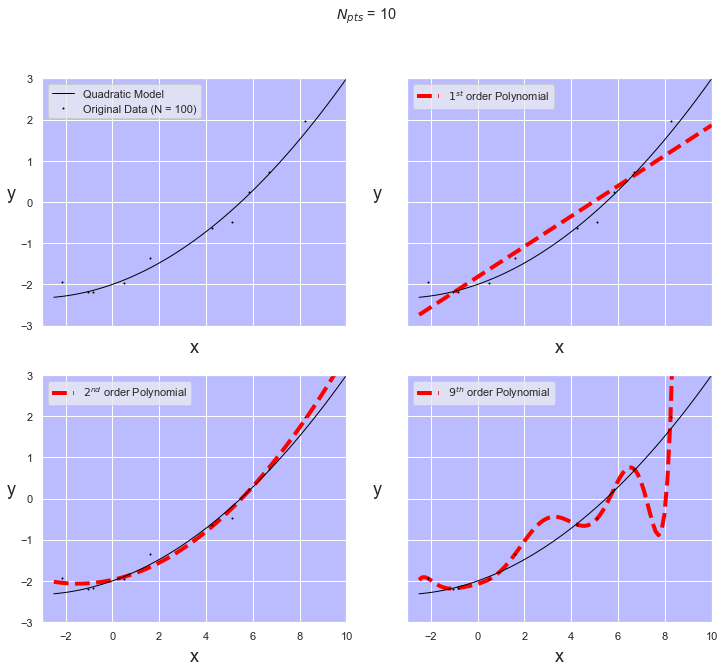

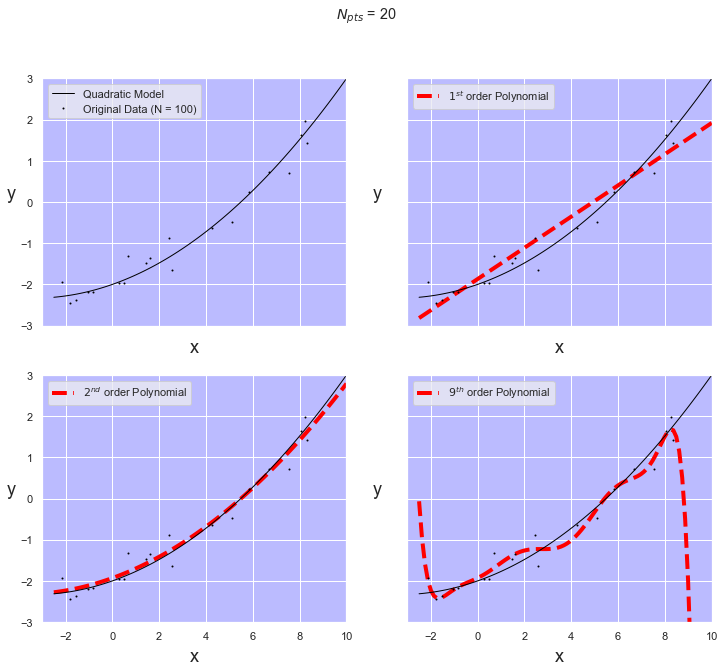

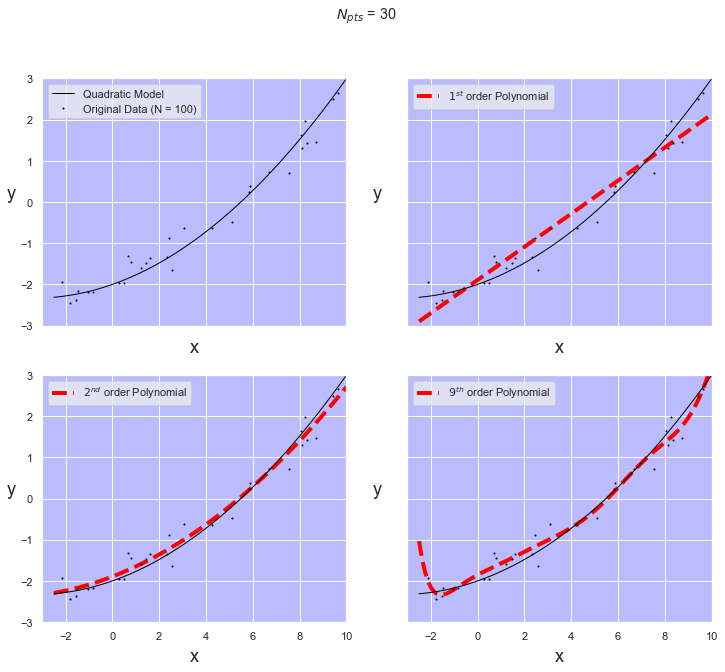

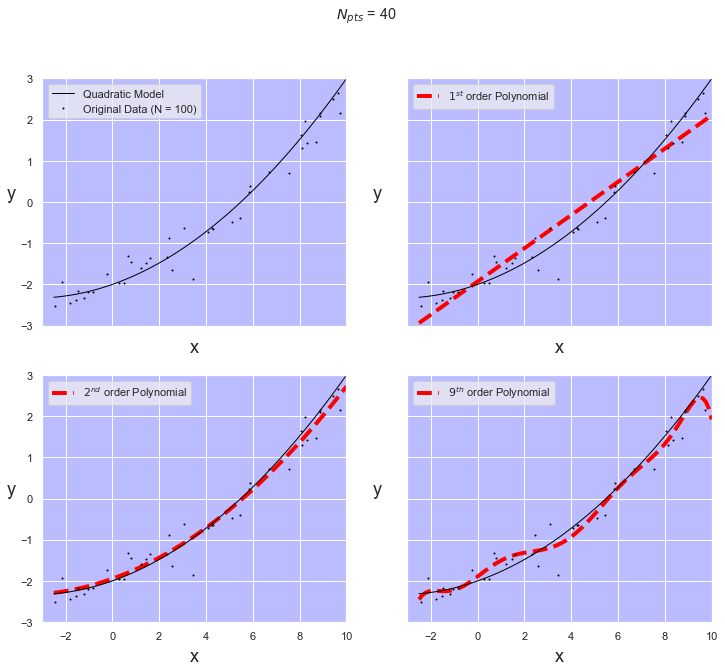

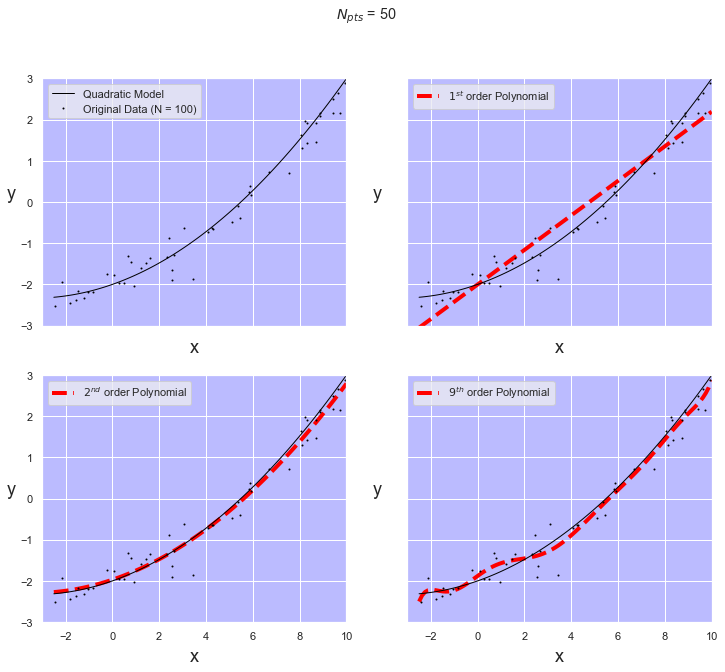

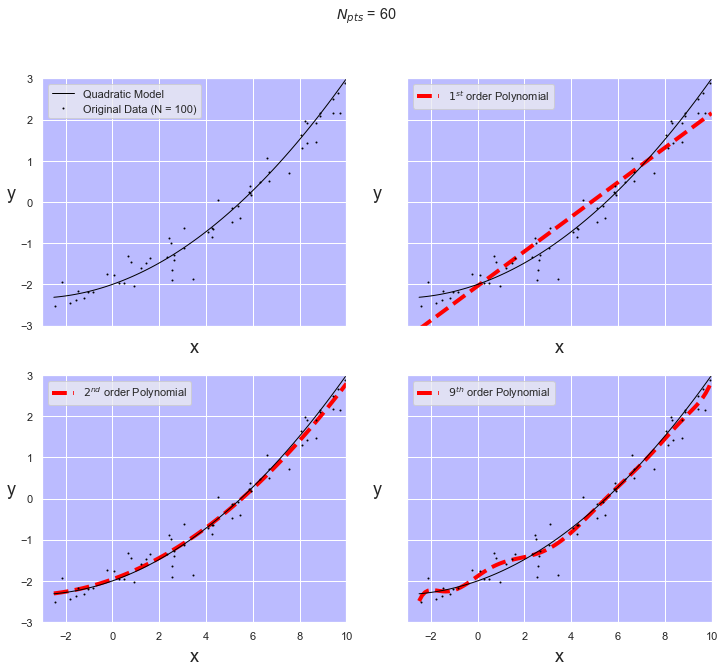

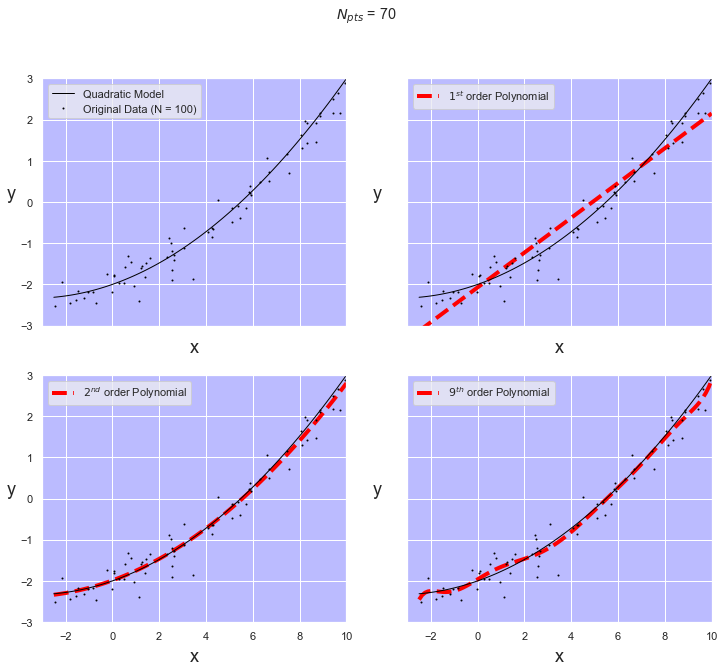

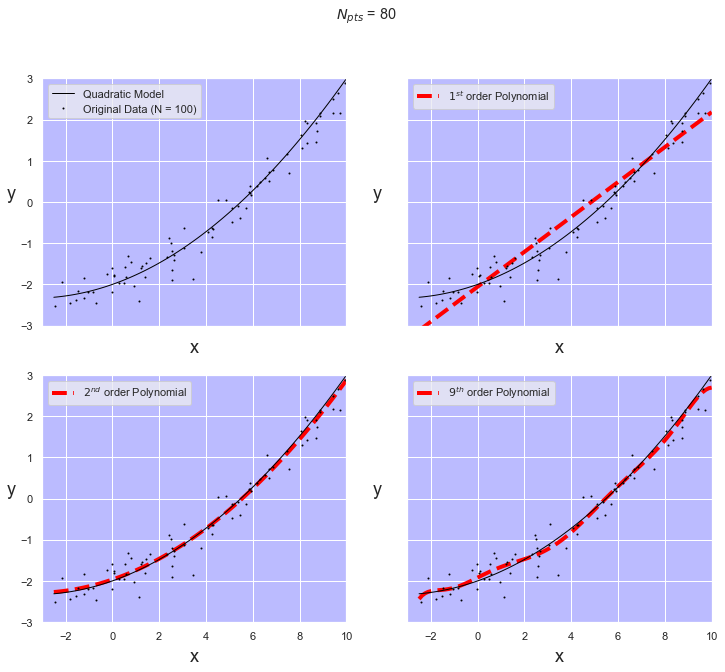

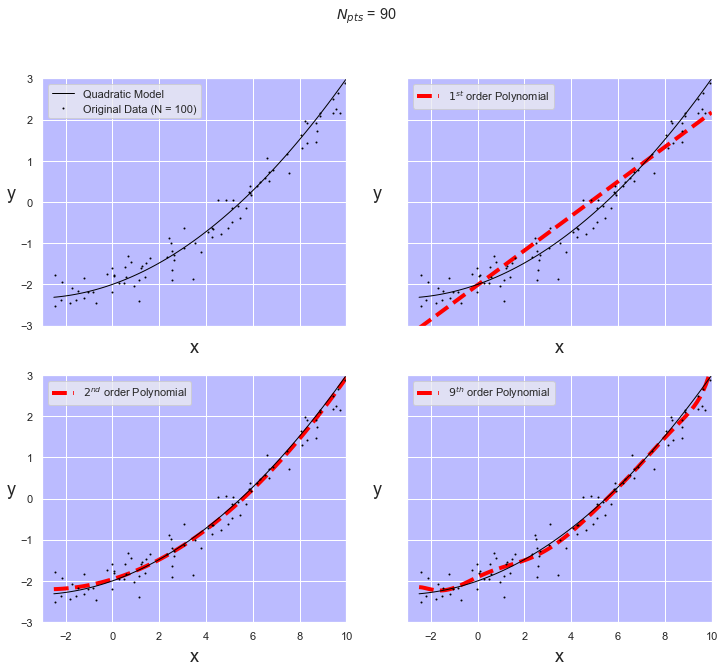

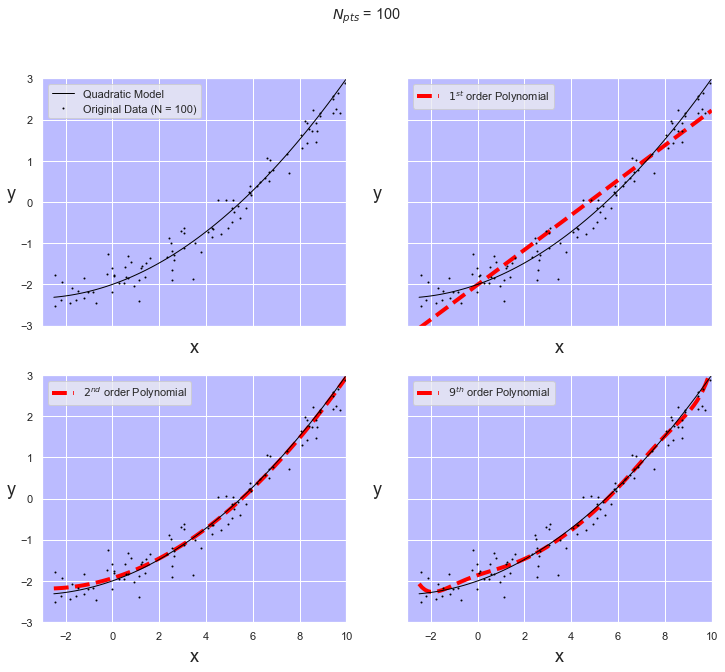

In [7]:
# Least-squares polynomial fitting with an increasing number of data points.
for i in range(10,110,10):
    # Sample the dataset
    x = X[0:i]
    y = Y[0:i]
    title = "$N_{pts}$ = %d" % i
    generate_fits(i, title)

generate_video(video_name='Effect_of_dataset_size_on_fits.avi')

## Regression examples with a varying noise level

Once again, the linear regression poorly performs at all noise levels for the same reason as before; it is too simple a model
for the datasets used. At low noise levels, the $9^{th}$ order polynomial is complex enough to approximate the shape 
of the baseline until this information is lost in the noise.


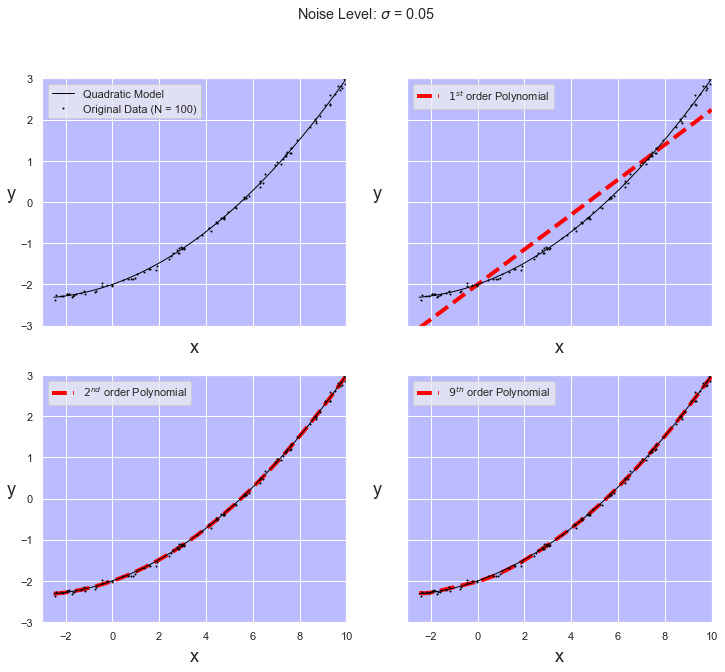

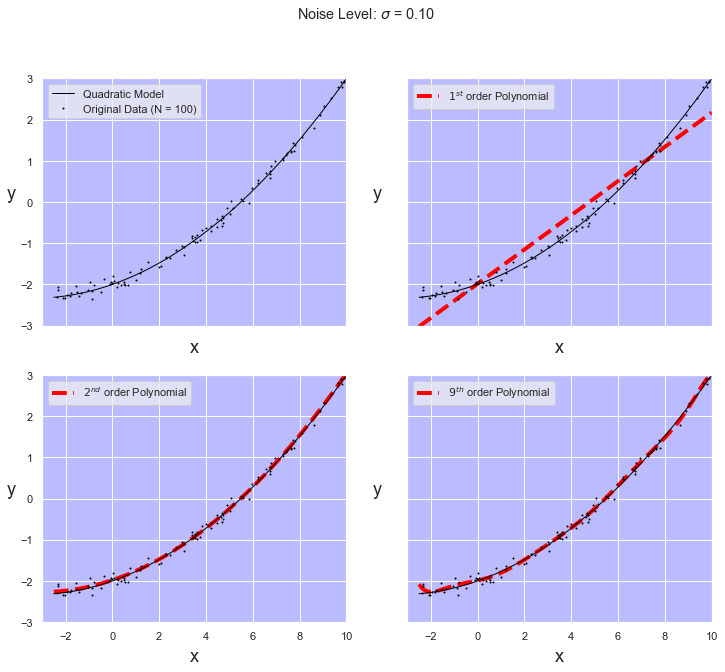

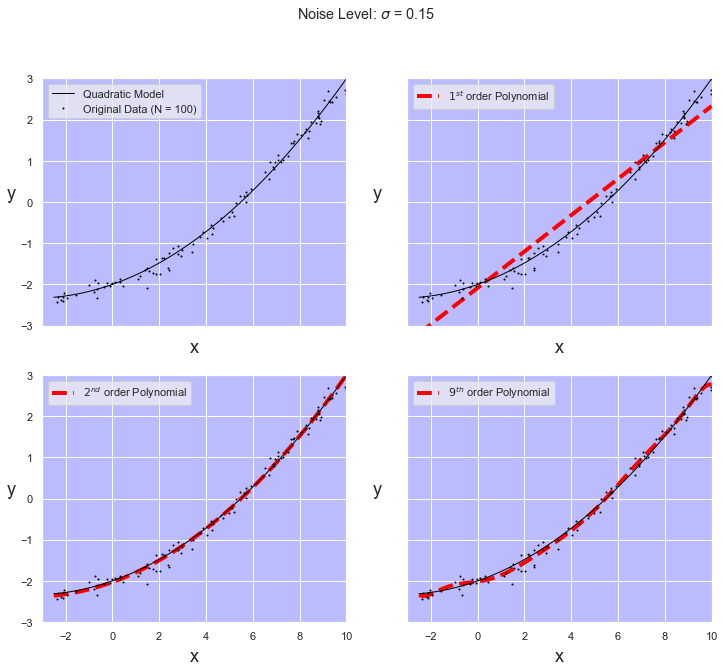

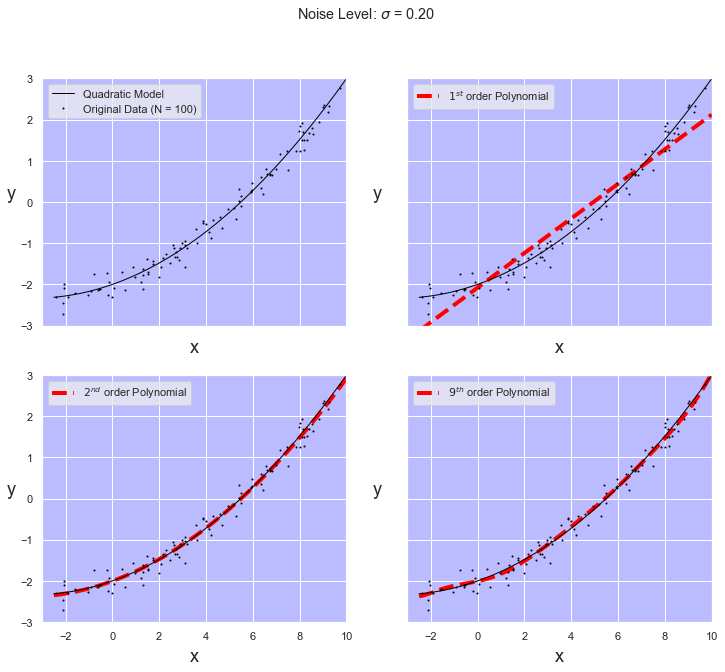

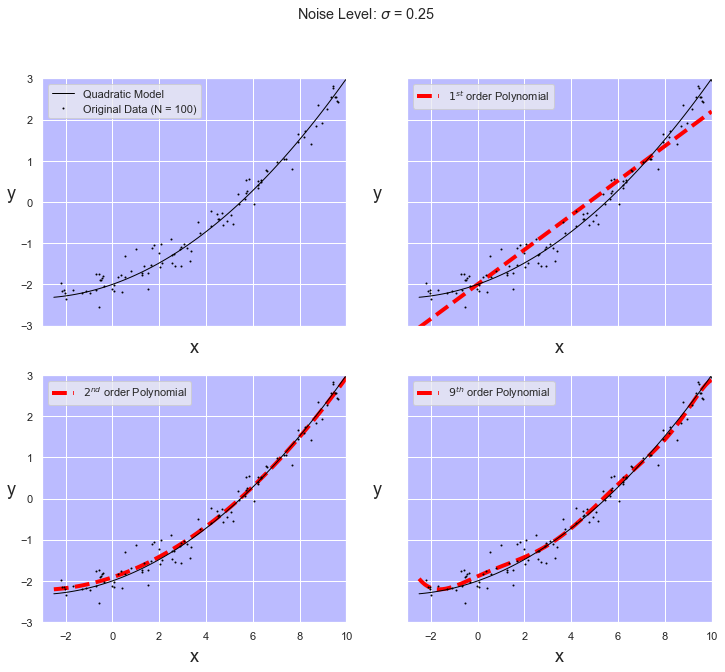

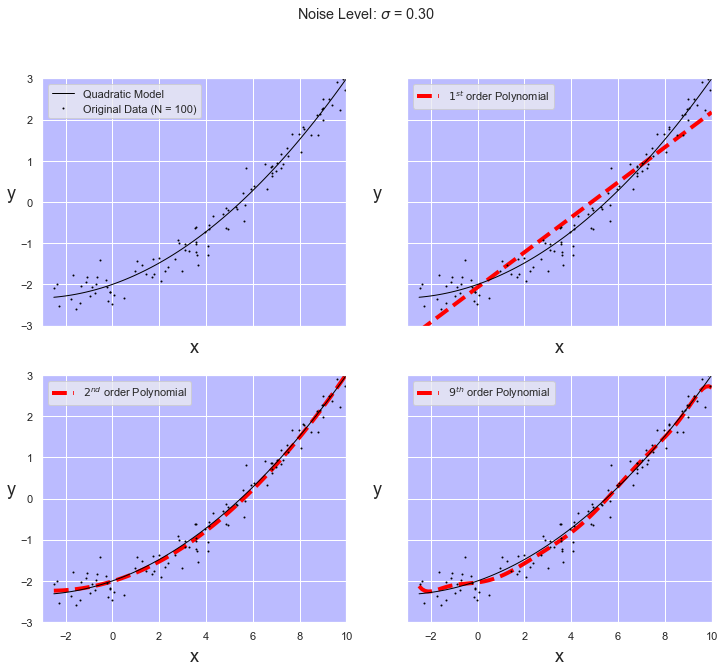

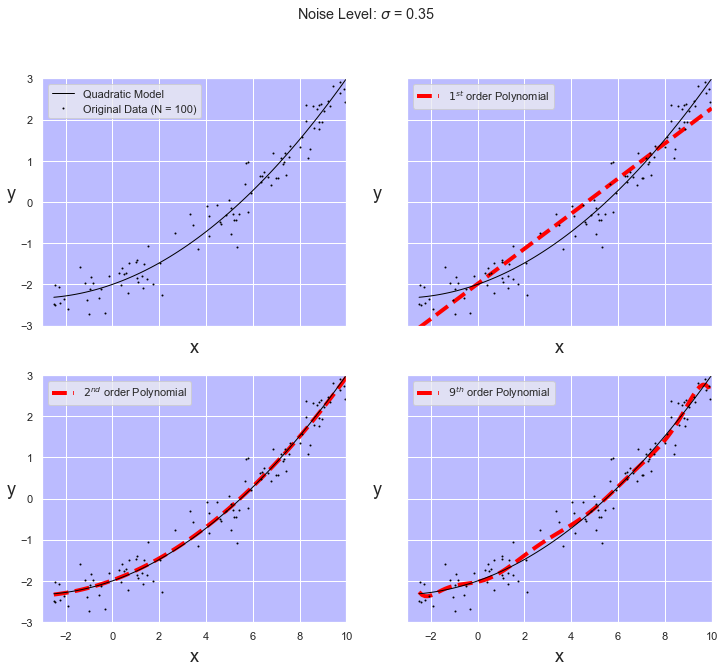

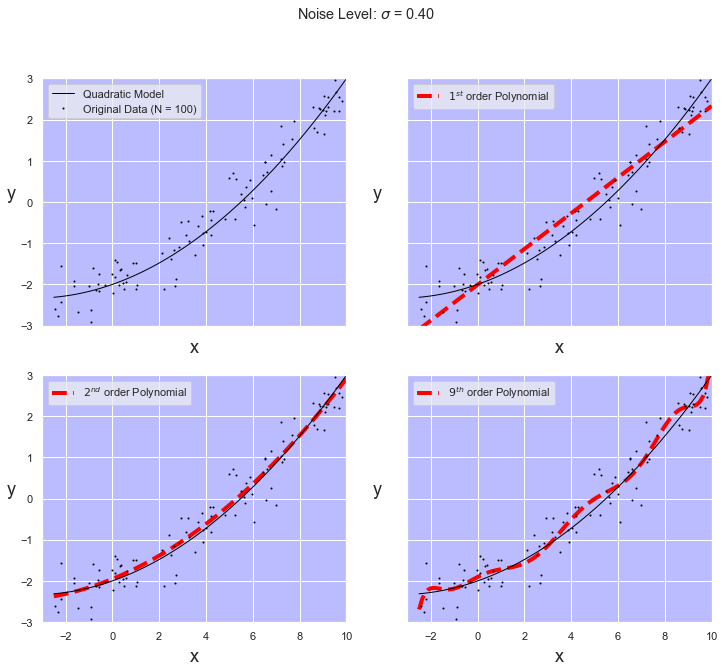

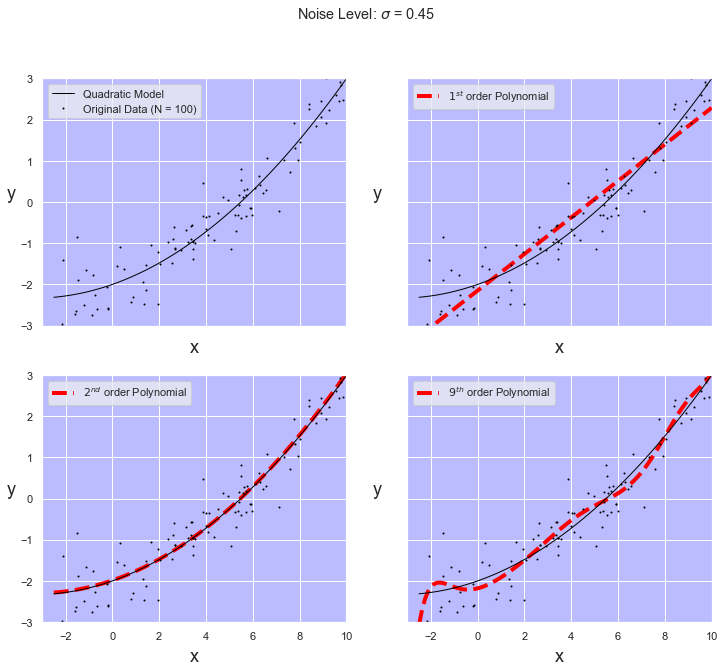

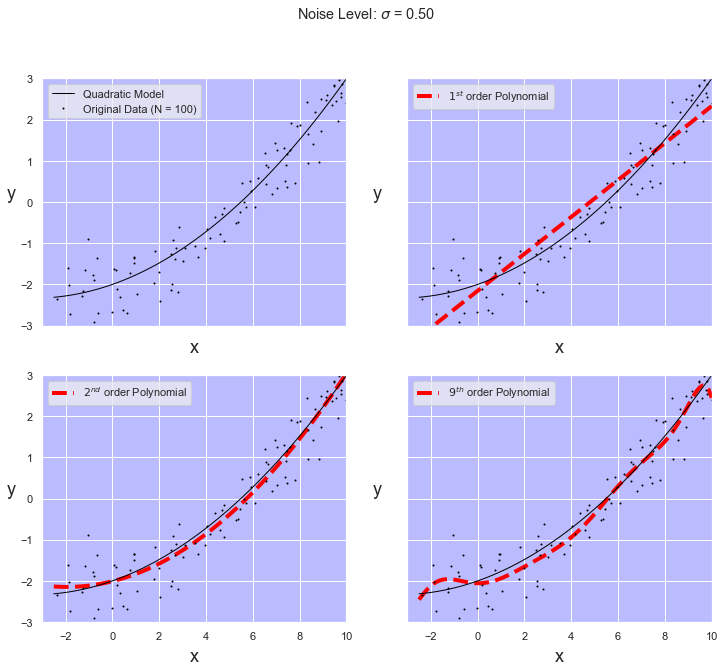

In [8]:
# Generate a large dataset
N = 100

# Vary the noise level
sigmas = np.linspace(0.05, 0.5, 10)

for i, sigma in enumerate(sigmas):
    x,y = generate_data(N, sigma)
    title = "Noise Level: $\sigma$ = %.2f" % sigma
    generate_fits(i, title)

generate_video(video_name='Effect_of_noise_level_on_fits.avi')